In [1]:
import cv2
import numpy as np
import tensorflow as tf

2024-09-18 14:58:40.757010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 14:58:40.757046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 14:58:40.758542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 14:58:40.766791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset = np.load("../../numpy_arr_data/train_img.npy")
mask_dataset = np.load("../../numpy_arr_data/vegetation_mask_img.npy")

In [3]:
train_dataset.shape, mask_dataset.shape

((2975, 512, 512, 3), (2975, 512, 512, 3))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
gray_mask = []
for mask in mask_dataset:
    mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    gray_mask.append(mask) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


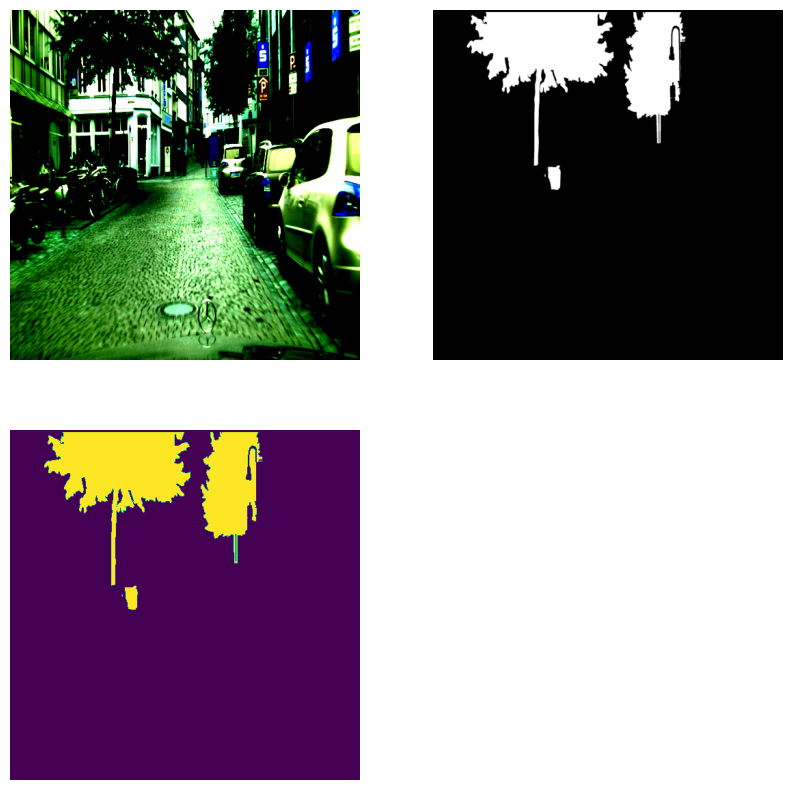

In [6]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [train_dataset[0], mask_dataset[0], gray_mask[0]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis
    

# Show the plot
plt.show()

In [7]:
gray_mask = np.array(gray_mask)
gray_mask = gray_mask[...,np.newaxis]

In [8]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, image_data, mask_data, batch_size=32, shuffle=True):
        self.image_data = image_data
        self.mask_data = mask_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Step 2: Define data augmentation
        self.image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        self.mask_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        self.on_epoch_end()
    
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.image_data) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        batch_image_data = [self.image_data[k] for k in indexes]
        batch_mask_data = [self.mask_data[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(batch_image_data, batch_mask_data)
        
        return X, y
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.image_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_image_data, batch_mask_data):
        # Resize images and masks to the target shape (224, 224)
        resized_images = [tf.image.resize(image, (256, 256)).numpy() for image in batch_image_data]
        resized_masks = [tf.image.resize(mask, (256, 256)).numpy() for mask in batch_mask_data]
        
        # Convert lists to numpy arrays
        X = np.array(resized_images)
        y = np.array(resized_masks)
        
        # Apply data augmentation
        for i in range(X.shape[0]):
            seed = np.random.randint(0, 10000)
            X[i] = self.image_datagen.random_transform(X[i], seed=seed)
            y[i] = self.mask_datagen.random_transform(y[i], seed=seed)
        
        return X, y


In [94]:
# Validation generator
train_generator = DataGenerator(train_dataset, gray_mask, batch_size=16, shuffle=True)

In [95]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256,256,3), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    # 'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [96]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

up_stack = [
    # pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [97]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [98]:
OUTPUT_CLASSES = 3
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [99]:
histroy = model.fit(train_generator, epochs=20, verbose=1, shuffle=True)

Epoch 1/20
185/185 [==============================] - 82s 417ms/step - loss: 0.7260 - accuracy: 0.9337
Epoch 2/20
185/185 [==============================] - 78s 423ms/step - loss: 0.4308 - accuracy: 0.9013
Epoch 3/20
185/185 [==============================] - 78s 421ms/step - loss: 0.3435 - accuracy: 0.8221
Epoch 4/20
185/185 [==============================] - 78s 420ms/step - loss: 0.3186 - accuracy: 0.8354
Epoch 5/20
185/185 [==============================] - 78s 419ms/step - loss: 0.3258 - accuracy: 0.8450
Epoch 6/20
185/185 [==============================] - 78s 420ms/step - loss: 0.2864 - accuracy: 0.9214
Epoch 7/20
185/185 [==============================] - 78s 421ms/step - loss: 0.2326 - accuracy: 0.9815
Epoch 8/20
185/185 [==============================] - 78s 420ms/step - loss: 0.1899 - accuracy: 0.9941
Epoch 9/20
185/185 [==============================] - 78s 420ms/step - loss: 0.1782 - accuracy: 0.9959
Epoch 10/20
185/185 [==============================] - 78s 421ms/step - l

In [101]:
model.save('../model/mobile_net_v2_dm_2_16.keras')

### **Testing Model**

In [3]:
model = tf.keras.models.load_model("../model/mobilenet_model/mobilenet_model_224_30.keras")

2024-09-18 14:58:49.102199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 14:58:49.113092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 14:58:49.116514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
import numpy as  np
import matplotlib.pyplot as plt
test_image = np.load("../../numpy_arr_data/test_img.npy")
mask_image = np.load("../../numpy_arr_data/test_vegetation_mask_gray_img.npy")
mask_image = mask_image[..., np.newaxis]

In [5]:
def resize_images(images, target_size=(224, 224)):
    """
    Resize images to the target size.
    """
    resized_images = [tf.image.resize(image, target_size).numpy() for image in images]
    return np.array(resized_images)
test_image = resize_images(test_image)
mask_image = resize_images(mask_image)

In [6]:
test_image.shape, mask_image.shape

((500, 224, 224, 3), (500, 224, 224, 1))

In [124]:
# test_image = [tf.image.resize(image, (224, 224)).numpy() for image in test_image]
# test_image = np.array(test_image)
test_image[:1].shape

(1, 224, 224, 3)

In [7]:
predicted = model.predict(test_image, verbose=1)

2024-09-18 15:00:11.744266: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


16/16 [==============================] - 7s 231ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


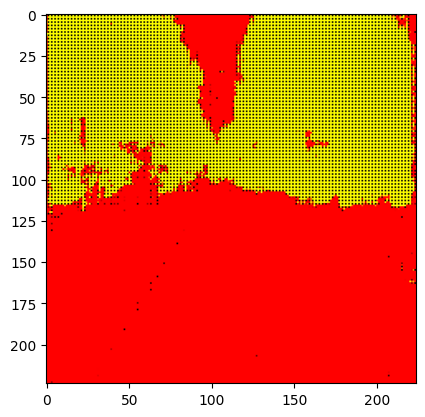

In [8]:
plt.imshow(predicted[0])

In [9]:
pred_mask = []
for mask in predicted:
    mask = cv2.medianBlur(mask, 5)
    mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    pred_mask.append(mask) 

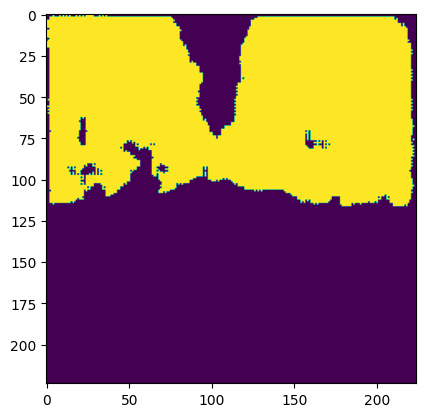

In [10]:
plt.imshow(pred_mask[0])

In [14]:
mask_image = np.squeeze(mask_image)
mask_image.shape

(500, 224, 224)

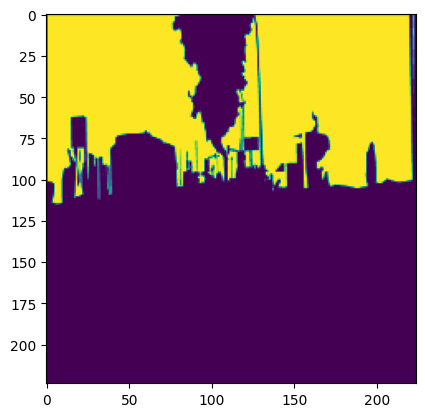

In [15]:
plt.imshow(mask_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


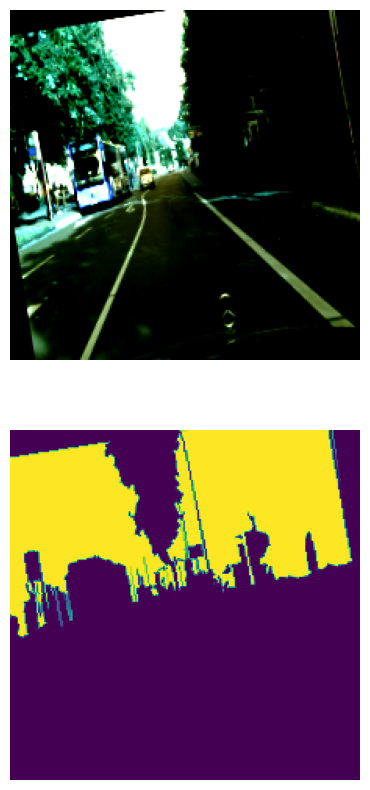

In [22]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [test_image[0], mask_image[0]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()

In [23]:
from skimage.transform import resize
mask_image = [resize(mask,(224,224),preserve_range=True) for mask in mask_image]

In [16]:
mask_image = np.array(mask_image)
pred_mask = np.array(pred_mask)

In [17]:
mask_image.shape, pred_mask.shape

((500, 224, 224), (500, 224, 224))

In [18]:
def calculating_iou(true_mask, pred_mask):
    arr_iou=[]
    for i in range(len(true_mask)):
        intersection = np.logical_and(true_mask[i],pred_mask[i])
        union = np.logical_or(true_mask[i], pred_mask[i])
        iou_score = np.sum(intersection) / np.sum(union)
        arr_iou.append(iou_score)
    arr_iou=np.array(arr_iou)
    arr_iou= np.nan_to_num(arr_iou, copy=True, nan=1.0)
    mean_iou=arr_iou.mean()
    return mean_iou

In [19]:
calculating_iou(mask_image, pred_mask)

0.5600116146324919

### **Notes**
1. Data augmenatation of image and mask
2. Try Batch Size 4 ,8, 16, 32,
3. Add seeding 5 is the average.
4. New data augementation technique

In [ ]:
unet v3, xceptnet3